In [119]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [120]:
import finance
import tradingbot

In [121]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']

In [122]:
a = 0
b = 1750
c = 250

In [123]:
learn_env = finance.Finance(symbol, features, window=20, lags=3,
                            leverage=1, min_performance=0.9, min_accuracy=0.475,
                            start=a, end=a + b, mu=None, std=None)

In [124]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.7 KB


In [125]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window, lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a + b, end=a + b + c,
                            mu=learn_env.mu, std=learn_env.std)

In [126]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [127]:
tradingbot.set_seeds(100)

In [128]:
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)

In [129]:
episodes = 61

In [130]:
agent.learn(episodes)

episode: 10/61 | VALIDATION | treward:  247 | perf: 1.112 | eps: 0.92
episode: 20/61 | VALIDATION | treward:  247 | perf: 1.114 | eps: 0.83
episode: 30/61 | VALIDATION | treward:  247 | perf: 0.887 | eps: 0.75
episode: 40/61 | VALIDATION | treward:  247 | perf: 1.189 | eps: 0.68
episode: 50/61 | VALIDATION | treward:  247 | perf: 1.031 | eps: 0.62
episode: 60/61 | VALIDATION | treward:  247 | perf: 1.132 | eps: 0.56
episode: 61/61 | treward:   16 | perf: 0.977 | av:  55.2 | max:  924


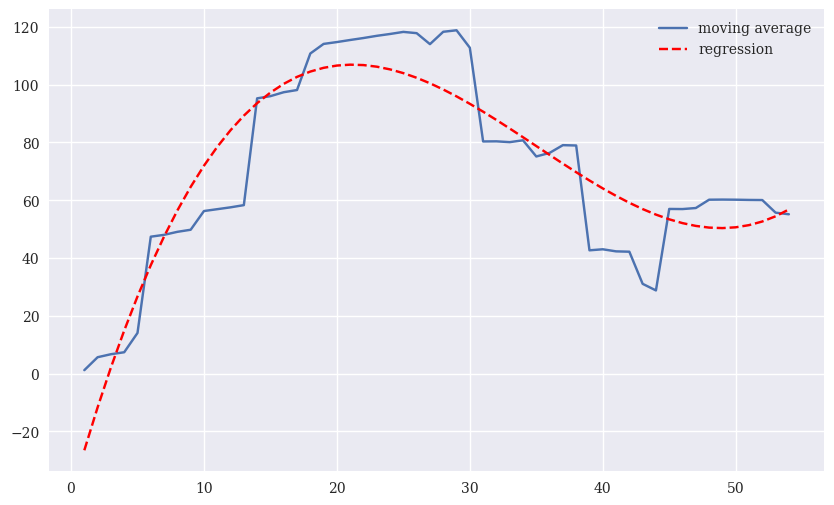

In [131]:
tradingbot.plot_treward(agent)

TypeError: expected x and y to have same length

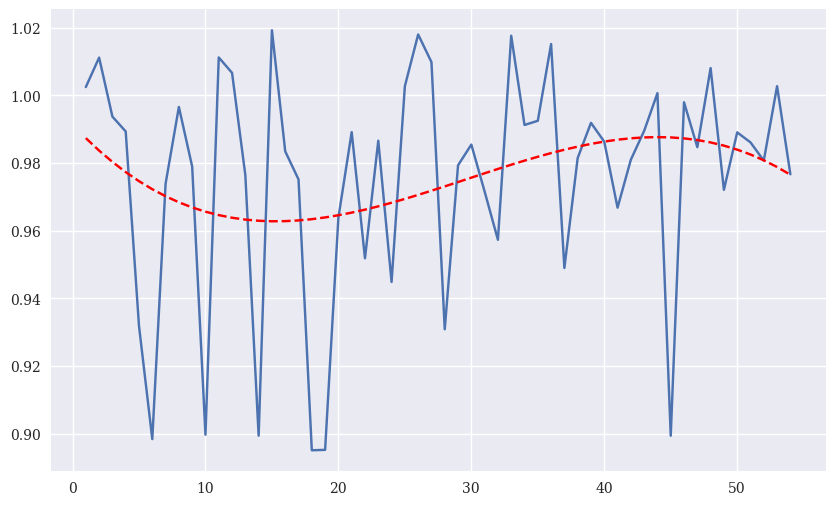

In [132]:
tradingbot.plot_performance(agent)

In [133]:
def reshape(s):
    return np.reshape(s, [1, learn_env.lags,
                          learn_env.n_features])

In [134]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state), verbose=0)[0, 0]
        )
        position = 1 if action == 1 else -1
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [135]:
env = agent.learn_env

In [136]:
backtest(agent, env)

In [137]:
env.data['p'].iloc[env.lags:].value_counts()

-1    1039
 1     708
Name: p, dtype: int64

In [138]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.7725
s   1.8054
dtype: float64

<Axes: xlabel='Date'>

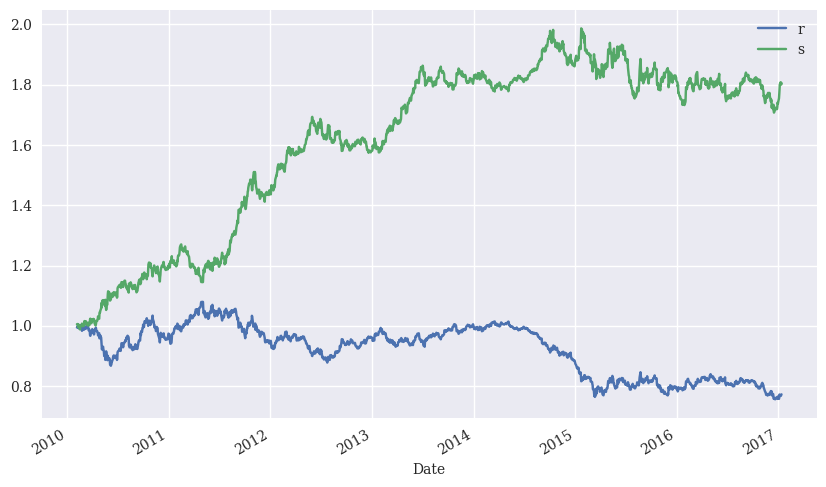

In [139]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [140]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, min_accuracy=0.0,
                           start=a + b + c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [141]:
env = test_env

In [142]:
backtest(agent, env)

In [143]:
env.data['p'].iloc[env.lags:].value_counts()

 1    307
-1    186
Name: p, dtype: int64

In [144]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.9144
s   0.9331
dtype: float64

<Axes: xlabel='Date'>

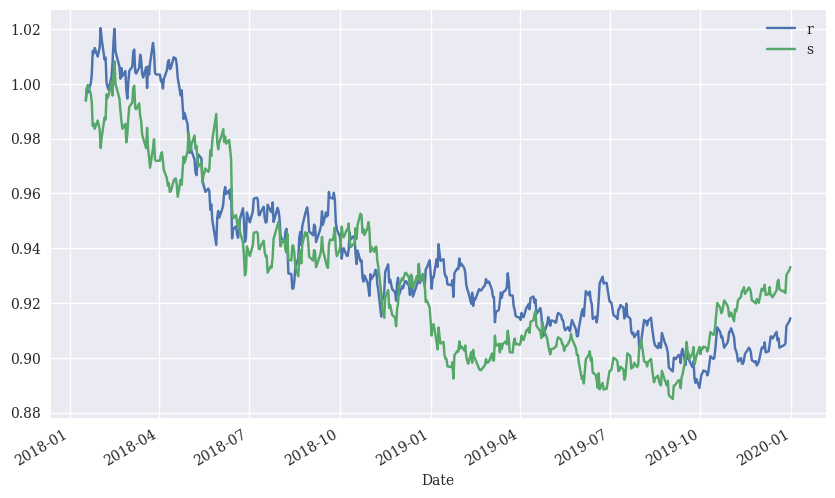

In [145]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [146]:
import backtesting as bt

In [147]:
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
                        amount=10000, ptc=0.0001, ftc=1.0,
                        verbose=True)

In [148]:
bb.initial_amount

10000

In [149]:
bar = 100

In [150]:
bb.get_date_price(bar)

('2010-06-25', 1.2374)

In [151]:
bb.env.get_state(bar)

,EUR=,r,s,m,v
Date,,,,,
2010-06-22,-0.0242,-0.5622,-0.0916,-0.2022,1.5316
2010-06-23,0.0176,0.6940,-0.0939,-0.0915,1.5563
2010-06-24,0.0354,0.3034,-0.0865,0.6391,1.0890


In [152]:
bb.place_buy_order(bar, amount=5000)

2010-06-25 | buy 4040 units for 1.2374
2010-06-25 | current balance = 4999.40


In [153]:
bb.print_net_wealth(2 * bar)

2010-11-16 | net wealth = 10450.17


In [154]:
bb.place_sell_order(2 * bar, units=1000)

2010-11-16 | sell 1000 units for 1.3492
2010-11-16 | current balance = 6347.47


In [155]:
bb.close_out(3 * bar)

2011-04-11 | *** CLOSING OUT ***
2011-04-11 | sell 3040 units for 1.4434
2011-04-11 | current balance = 10733.97
2011-04-11 | net performance [%] = 7.3397
2011-04-11 | number of trades [#] = 3


In [156]:
env = learn_env

In [157]:
from tbbacktester import TBBacktesterRM

In [158]:
tb = TBBacktesterRM(env, agent.model, 10000, 0.0, 0, verbose=False)

In [159]:
agent.model.save('test_model')

INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


In [160]:
import tensorflow as tf

In [161]:
test_model = tf.keras.models.load_model('test_model')

In [162]:
test_model

In [163]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 17392.17
2017-01-12 | net performance [%] = 73.9217
2017-01-12 | number of trades [#] = 964


In [164]:
tb_ = TBBacktesterRM(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [165]:
tb_.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 15494.54
2017-01-12 | net performance [%] = 54.9454
2017-01-12 | number of trades [#] = 964


<Axes: xlabel='date'>

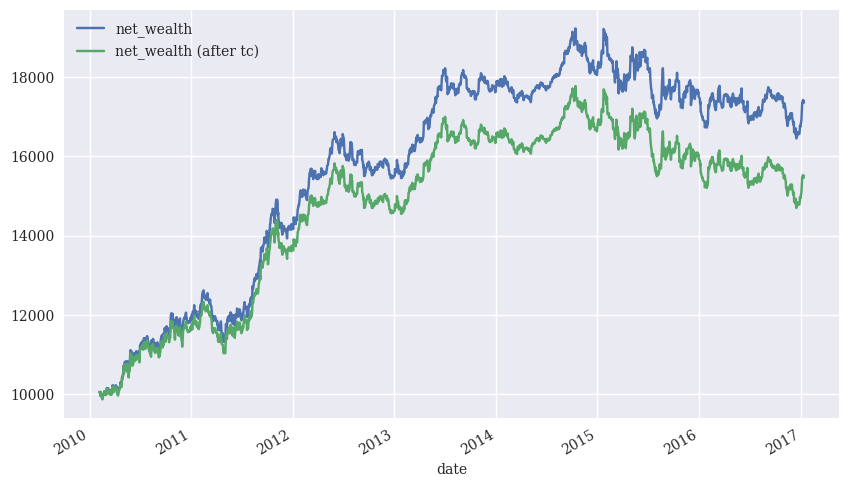

In [166]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax)

In [167]:
env = test_env

In [168]:
tb = TBBacktesterRM(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [169]:
tb.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9305.72
2019-12-31 | net performance [%] = -6.9428
2019-12-31 | number of trades [#] = 378


In [170]:
tb_ = TBBacktesterRM(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [171]:
tb_.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 8892.94
2019-12-31 | net performance [%] = -11.0706
2019-12-31 | number of trades [#] = 378


<Axes: xlabel='date'>

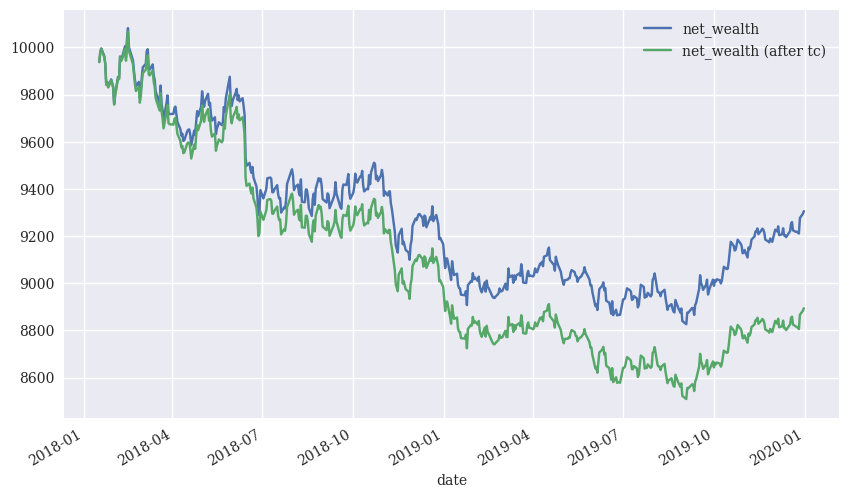

In [172]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax)

<Axes: xlabel='Date'>

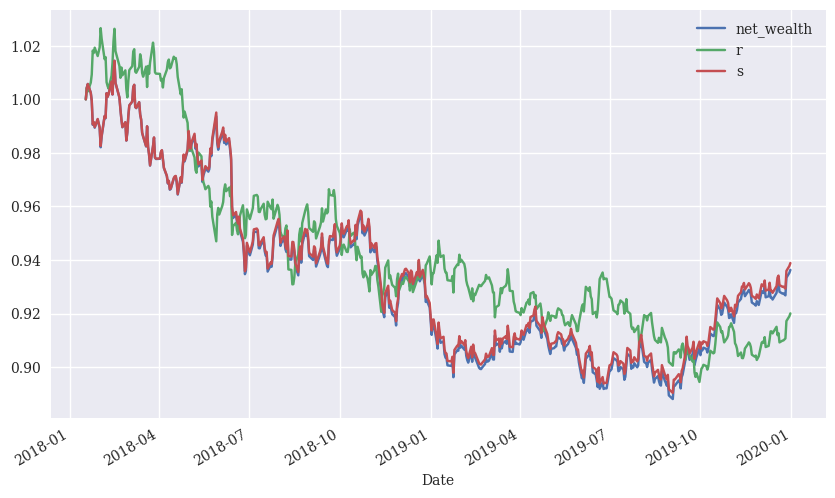

In [173]:
ax = (tb.net_wealths / tb.net_wealths.iloc[0]).plot(figsize=(10, 6))
tp = env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp)
(tp / tp.iloc[0]).plot(ax=ax)

In [174]:
data = pd.DataFrame(learn_env.data[symbol])
data.head()

,EUR=
Date,
2010-02-02,1.3961
2010-02-03,1.3898
2010-02-04,1.3734
2010-02-05,1.3662
2010-02-08,1.3652


In [175]:
window = 14

In [176]:
data['min'] = data[symbol].rolling(window).min()

In [177]:
data['max'] = data[symbol].rolling(window).max()

In [178]:
data['mami'] = data['max'] - data['min']

In [179]:
data['mac'] = abs(data['max'] - data[symbol].shift(1))

In [180]:
data['mic'] = abs(data['min'] - data[symbol].shift(1))

In [181]:
data['atr'] = np.maximum(data['mami'], data['mac'])

In [182]:
data['atr'] = np.maximum(data['atr'], data['mic'])

In [183]:
data['atr%'] = data['atr'] / data[symbol]

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

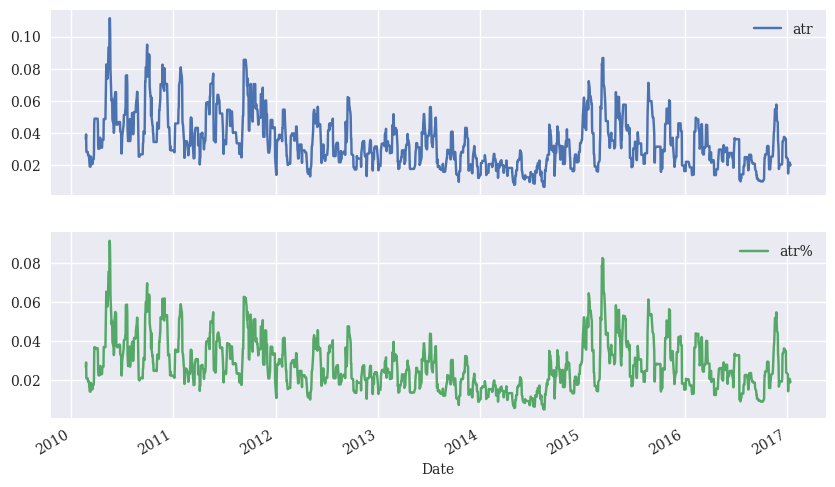

In [184]:
data[['atr', 'atr%']].plot(subplots=True, figsize=(10, 6))

In [185]:
data[['atr', 'atr%']].tail()

,atr,atr%
Date,,
2017-01-06,0.0218,0.0207
2017-01-09,0.0218,0.0206
2017-01-10,0.0218,0.0207
2017-01-11,0.0199,0.0188
2017-01-12,0.0206,0.0194


In [186]:
leverage = 10

In [187]:
data[['atr', 'atr%']].tail() * leverage

,atr,atr%
Date,,
2017-01-06,0.2180,0.2070
2017-01-09,0.2180,0.2062
2017-01-10,0.2180,0.2066
2017-01-11,0.1990,0.1881
2017-01-12,0.2060,0.1942


In [188]:
data[['atr', 'atr%']].median() * leverage

atr    0.3180
atr%   0.2481
dtype: float64

In [189]:
env = test_env

In [190]:
tb = TBBacktesterRM(env, agent.model, 10000, 0.0, 0, verbose=False)

In [191]:
tb.backtest_strategy(sl=None, tsl=None, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9305.72
2019-12-31 | net performance [%] = -6.9428
2019-12-31 | number of trades [#] = 378


In [192]:
tb.backtest_strategy(sl=0.0175, tsl=None, tp=None, wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0221) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0181) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9133.56
2019-12-31 | net performance [%] = -8.6644
2019-12-31 | number of trades [#] = 376


In [193]:
tb.backtest_strategy(sl=0.017, tsl=None, tp=None, wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0170) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9192.01
2019-12-31 | net performance [%] = -8.0799
2019-12-31 | number of trades [#] = 376


In [194]:
tb.backtest_strategy(sl=None, tsl=0.015, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0221) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0181) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0154) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0160) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0181) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0157) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9273.51
2019-12-31 | net performance [%] = -7.2649
2019-12-31 | number of trades [#] = 368


In [195]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015, wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0171) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0151) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0158) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0172) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0187) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9420.21
2019-12-31 | net performance [%] = -5.7979
2019-12-31 | number of trades [#] = 374


In [196]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015, wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0150) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9337.65
2019-12-31 | net performance [%] = -6.6235
2019-12-31 | number of trades [#] = 374


In [197]:
tb.backtest_strategy(sl=0.015, tsl=None, tp=0.0185, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0221) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0238) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0253) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0154) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0160) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0186) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0181) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0187) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9406.93
2019-12-31 | net performance [%] = -5.9307
2019-12-31 | number of trades [#] = 364
